# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
from collections import namedtuple, deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
LR_ACTOR = 5e-4
LR_CRITIC = 5e-4
TAU = 1e-3
WEIGHT_DECAY = 0.0
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
GAMMA = 0.99
UPDATE_EVERY = 1
ADD_NOISE = True
NOISE_FACTOR_START = 1.0
NOISE_REDUCTION = 0.90
RANDOM_SEED = 0

In [8]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256, use_BatchNorm=True):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.use_BatchNorm = use_BatchNorm
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        if self.use_BatchNorm:
            self.bn1 = nn.BatchNorm1d(fc1_units)

    def forward(self, state):
        if self.use_BatchNorm and state.dim()==1:
            state = torch.unsqueeze(state, 0)
        
        x = F.relu(self.fc1(state))
        
        if self.use_BatchNorm:
            x = self.bn1(x)
            
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, all_state_size, all_action_size, seed, fcs1_units=256, fc2_units=256, use_BatchNorm=True):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.use_BatchNorm = use_BatchNorm

        self.fcs1 = nn.Linear(all_state_size+all_action_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)

        self.fc3 = nn.Linear(fc2_units, 1)
        
        if self.use_BatchNorm:
            self.bn1 = nn.BatchNorm1d(fcs1_units)

    def forward(self, states, actions):
        x = torch.cat((states, actions), dim=1)
        x = F.relu(self.fcs1(x))
        if self.use_BatchNorm:
            x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
class MADDPGAgent:
    
    def __init__(self, num_agents, state_size, action_size):
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(RANDOM_SEED)
        self.noise_factor = NOISE_FACTOR_START
        self.t_step = 0

        self.agents = [DDPGAgent(i, self.num_agents, self.state_size, self.action_size, RANDOM_SEED) for i in range(num_agents)]
        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)
        
    def step(self, states, actions, rewards, next_states, dones):
        self.memory.add(states, actions, rewards, next_states, dones)
        
        self.t_step = self.t_step + 1
        if self.t_step % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = [ self.memory.sample() for k in range(self.num_agents) ]
                self.learn(experiences, GAMMA)

    def act(self, states):
        actions = []
        for agent in self.agents:
            action = agent.act(states[agent.agent_id], self.noise_factor, ADD_NOISE)
            actions.append(action)
        
        self.noise_factor = self.noise_factor * NOISE_REDUCTION
        return np.array(actions).reshape(-1)

    def reset(self):
        for agent in self.agents:
            agent.reset()
  
    def learn(self, experiences, gamma):
        for agent_id, agent in enumerate(self.agents):
            states, actions, rewards, next_states, dones = experiences[agent_id]
            next_state = next_states[:, agent_id, :]
            if agent_id == 0:
                other_next_actions = self.agents[1].actor_target(next_state).detach()
            else:
                other_next_actions = self.agents[0].actor_target(next_state).detach()
            agent.learn(experiences[agent_id], gamma, other_next_actions)

class DDPGAgent:
    
    def __init__(self, agent_id, num_agents, state_size, action_size, random_seed):
        self.agent_id = agent_id
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed=0).to(device)
        self.actor_target = Actor(state_size, action_size, seed=0).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents * state_size, num_agents * action_size, seed=0).to(device)
        self.critic_target = Critic(num_agents * state_size, num_agents * action_size, seed=0).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

    def act(self, state, noise_factor=1.0, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * noise_factor
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, other_next_actions):
        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- data prep -------------------------------- #
        batch_size = states.shape[0]

        own_next_states = next_states[:, self.agent_id, :].reshape(batch_size, -1)
        own_states = states[:, self.agent_id, :].reshape(batch_size, -1)
        
        if self.agent_id == 0:
            other_actions = actions[:, 2:]
            own_rewards = rewards[:, :1]
            own_dones = dones[:, :1]
        else:
            other_actions = actions[:, :2]
            own_rewards = rewards[:, 1:]
            own_dones = dones[:, 1:]

        # flatten for input
        states = states.reshape(batch_size, -1)
        actions = actions.reshape(batch_size, -1)
        next_states = next_states.reshape(batch_size, -1)

        # ---------------------------- update critic ---------------------------- #
        actions_next = self.actor_target(own_next_states)
        if self.agent_id == 0:
            actions_next = torch.cat((actions_next, other_next_actions), dim=1).to(device)
        else:
            actions_next = torch.cat((other_next_actions, actions_next), dim=1).to(device)

        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states (y_i)
        Q_targets = own_rewards + (gamma * Q_targets_next * (1 - own_dones))
        Q_targets = Q_targets.detach()

        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)

        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        pred_actions = self.actor_local(own_states)

        if self.agent_id == 0:
            actions_pred = torch.cat((pred_actions, other_actions), dim=1).to(device)
        else:
            actions_pred = torch.cat((other_actions, pred_actions), dim=1).to(device)

        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))

        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
def maddpg(agent, n_episodes=3500, max_t=1000):
    scores = []
    scores_deque = deque(maxlen=100)
    scores_deque_mean = []
    solved = False
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        current_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            current_scores += rewards
            if np.any(dones):
                break 
        
        max_score = np.max(current_scores)
        scores.append(max_score)   
        scores_deque.append(max_score)
        
        scores_avg = np.mean(scores_deque)
        scores_deque_mean.append(scores_avg)
        
        print(f"\rEpisode {i_episode}\tAverage Score: {scores_avg:.3f}\t", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {scores_avg:.3f}".format(i_episode, scores_avg))   
        if np.mean(scores_deque)>=0.5:
            print(f"\nSolved in {i_episode} episodes!\tAverage Score: {scores_avg:.3f}")
            
            for i, agent in enumerate(agent.agents):
                torch.save(agent.actor_local.state_dict(), f"agent_{i}_actor_model.pth")
                torch.save(agent.critic_local.state_dict(), f"agent_{i}_critic_model.pth")
                
            solved = True
            break
    return scores, scores_deque_mean, i_episode, solved

In [11]:
agent = MADDPGAgent(num_agents, state_size, action_size)

scores, scores_mean, num_episodes_solved, solved = maddpg(agent)

Episode 100	Average Score: 0.003	
Episode 200	Average Score: 0.007	
Episode 300	Average Score: 0.008	
Episode 400	Average Score: 0.000	
Episode 500	Average Score: 0.023	
Episode 600	Average Score: 0.041	
Episode 700	Average Score: 0.043	
Episode 800	Average Score: 0.040	
Episode 900	Average Score: 0.036	
Episode 1000	Average Score: 0.096	
Episode 1100	Average Score: 0.115	
Episode 1200	Average Score: 0.118	
Episode 1300	Average Score: 0.139	
Episode 1400	Average Score: 0.189	
Episode 1482	Average Score: 0.505	
Solved in 1482 episodes!	Average Score: 0.505


Text(0.5,0,'Episode')

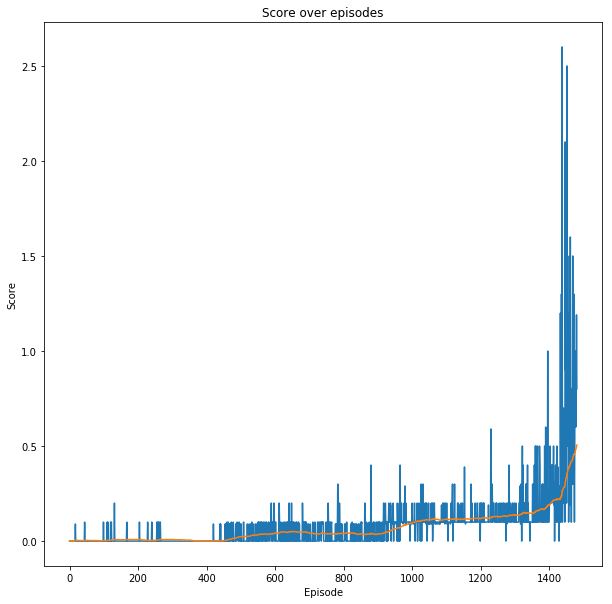

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(len(scores)), scores)
ax.plot(np.arange(len(scores_mean)), scores_mean)
ax.set_title("Score over episodes")
ax.set_ylabel("Score")
ax.set_xlabel("Episode")

In [13]:
env.close()